**AKBANK MAKİNE ÖĞRENMESİ BOOTCAMP**

Bu proje, Akbank Makine Öğrenmesi Bootcamp kapsamında gerçekleştirilmiştir. Amaç, Apple Inc. (AAPL) hisse senedinin kapanış fiyatlarını geçmiş veriler üzerinden tahmin etmektir.



Kaynak: [Kaggle - World Stock Prices](https://www.kaggle.com/datasets/nelgiriyewithana/world-stock-prices-daily-updating)
İçerik: Tüm dünyadan hisse senetlerinin günlük bazda fiyat bilgileri.
Kullanılan alt küme: AAPL (Apple Inc.)

In [50]:
import zipfile
import pandas as pd
import os

zip_path = "dataset.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("unzipped_data")  

print("İçerikteki dosyalar:")
print(os.listdir("unzipped_data"))

csv_file_path = os.path.join("unzipped_data", "world-stock-prices-dataset.csv")
df = pd.read_csv(csv_file_path)

print(df.head())



İçerikteki dosyalar:
['World-Stock-Prices-Dataset.csv']
                        Date         Open         High          Low  \
0  2025-05-23 00:00:00-04:00     6.960000     7.600000     6.920000   
1  2025-05-23 00:00:00-04:00   315.070007   315.649994   313.029999   
2  2025-05-23 00:00:00-04:00   108.089996   111.019997   107.669998   
3  2025-05-23 00:00:00-04:00  1184.000000  1191.449951  1179.439941   
4  2025-05-23 00:00:00-04:00    23.790001    23.860001    23.680000   

         Close      Volume  Dividends  Stock Splits   Brand_Name Ticker  \
0     7.570000  20631978.0        0.0           0.0      peloton   PTON   
1   314.570007   2701500.0        0.0           0.0   mcdonald's    MCD   
2   110.309998  30825000.0        0.0           0.0          amd    AMD   
3  1185.390015   2183400.0        0.0           0.0      netflix   NFLX   
4    23.709999   5505300.0        0.0           0.0  foot locker     FL   

    Industry_Tag Country  Capital Gains  
0        fitness     usa

In [51]:
df.info()
df.isnull().sum()
df.describe()

print("Unique Tickers:", df['Ticker'].nunique())
print("Date range:", df['Date'].min(), "to", df['Date'].max())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308150 entries, 0 to 308149
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           308150 non-null  object 
 1   Open           308150 non-null  float64
 2   High           308150 non-null  float64
 3   Low            308150 non-null  float64
 4   Close          308150 non-null  float64
 5   Volume         308150 non-null  float64
 6   Dividends      308150 non-null  float64
 7   Stock Splits   308150 non-null  float64
 8   Brand_Name     308150 non-null  object 
 9   Ticker         308150 non-null  object 
 10  Industry_Tag   308150 non-null  object 
 11  Country        308150 non-null  object 
 12  Capital Gains  2 non-null       float64
dtypes: float64(8), object(5)
memory usage: 30.6+ MB
Unique Tickers: 61
Date range: 2000-01-03 00:00:00-05:00 to 2025-05-23 00:00:00-04:00


In [52]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)


C:\Users\musta\AppData\Local\Temp\ipykernel_15724\1784743209.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


In [53]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df['Date'] = df['Date'].dt.tz_localize(None)


In [54]:
apple = df[df['Ticker'] == 'AAPL'][['Date', 'Close']]
apple['Date'] = pd.to_datetime(apple['Date'], utc=True).dt.tz_localize(None)
apple = apple.groupby('Date').mean()
apple = apple.asfreq('D')
apple['Close'].interpolate(method='time', inplace=True)


In [55]:
apple['lag_1'] = apple['Close'].shift(1)
apple['lag_2'] = apple['Close'].shift(2)
apple['lag_3'] = apple['Close'].shift(3)

apple.dropna(inplace=True)


In [56]:
from sklearn.model_selection import train_test_split

X = apple[['lag_1', 'lag_2', 'lag_3']]
y = apple['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [57]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np

#modeller
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'KNN': KNeighborsRegressor()
}

tscv = TimeSeriesSplit(n_splits=5)
results = {}

for name, model in models.items():
    neg_mse = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
    mse_scores = -neg_mse
    results[name] = mse_scores
    print(f"{name} - MSE Ortalaması: {mse_scores.mean():.4f}, Std: {mse_scores.std():.4f}")


LinearRegression - MSE Ortalaması: 0.3845, Std: 0.5795
Ridge - MSE Ortalaması: 0.3852, Std: 0.5791
Lasso - MSE Ortalaması: 5.4371, Std: 6.4408
KNN - MSE Ortalaması: 796.0470, Std: 976.8796


Aşağıdaki modeller `TimeSeriesSplit` ile çapraz doğrulamaya tabi tutuldu:
Linear Regression, 
Ridge Regression, 
Lasso Regression, 
KNN Regressor. En iyi performansı Linear Regression verdi.

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Final Model - MSE: {mse:.4f}, MAE: {mae:.4f}")


Final Model - MSE: 1.4501, MAE: 0.5289


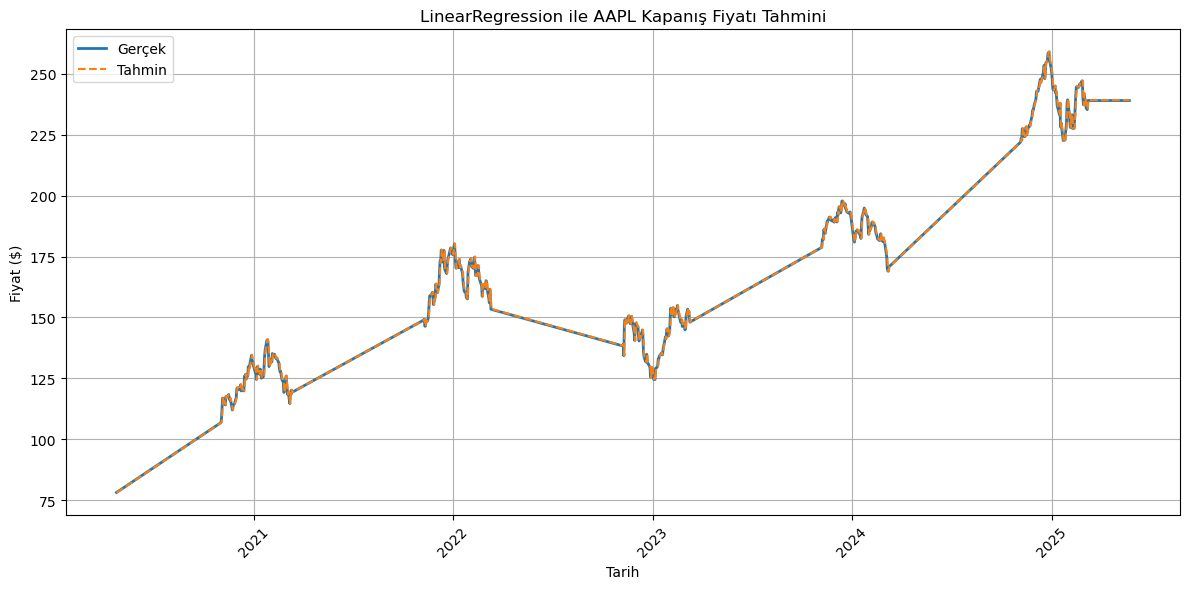

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Gerçek', linewidth=2)
plt.plot(y_test.index, y_pred, label='Tahmin', linestyle='--')
plt.title('LinearRegression ile AAPL Kapanış Fiyatı Tahmini')
plt.xlabel('Tarih')
plt.ylabel('Fiyat ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Hazırlayan: Neslihan Mustak

**Tarih: 25.05.2025**